# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly

from statsmodels.tsa.stattools import adfuller, ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
# Graph specs
#sns.set(rc={'figure.figsize':(11,8)})

In [4]:
#df = pd.read_csv('/Users/alentersakyan/Downloads/online_retail_1011.csv')

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [6]:
# Some missing info in Customer ID specifically. This doesn't matter for TS because we will group sales by day.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        1067371 non-null object
StockCode      1067371 non-null object
Description    1062989 non-null object
Quantity       1067371 non-null int64
InvoiceDate    1067371 non-null object
Price          1067371 non-null float64
Customer ID    824364 non-null float64
Country        1067371 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 73.3+ MB


### Missing Data

In [7]:
print((df['Customer ID'].isnull()).any())
df[df['Customer ID'].isnull()]

True


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
622,536414,22139,NaN,56,12/1/10 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/10 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/10 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/10 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/10 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,12/9/10 17:17,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,12/9/10 17:17,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,12/9/10 17:18,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,12/9/10 17:25,0.00,NaN,United Kingdom


In [8]:
# Need to remove negative values
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [9]:
# Remove negative quantity (cancelled or returned?)
df = df[df.Quantity > 0]

In [10]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


### Duplicates

In [12]:
print(df.duplicated().sum())
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

33881
(1010540, 8)


### Date-time index

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
# Get a truncated version of the date-- only year/month/day
def truncate_date(x): 
    return pd.datetime(x.year, x.month, x.day)

In [15]:
df['truncated_date'] = df['InvoiceDate'].apply(truncate_date)
df['truncated_date']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
502933   2010-11-30
502934   2010-11-30
502935   2010-11-30
502936   2010-11-30
502937   2010-11-30
Name: truncated_date, Length: 1010540, dtype: datetime64[ns]

In [16]:
df.set_index('truncated_date', inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
truncated_date,,,,,,,,
2010-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2010-12-01,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2010-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
2010-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2010-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
print('\nUnique dates in our data: ', len(df.index.unique()), 'Days')
date_range = df.index.max() - df.index.min()

# Calculate number of days in date range
print('Total days in our date range:', date_range.days, 'Days')
#date_range = pd.date_range(min(sales.index), max(sales.index))


Unique dates in our data:  604 Days
Total days in our date range: 738 Days


### Looks like df is missing some unique days-- will impute these later
- To be a true time series we can't have gaps

In [18]:
df['Revenue'] = df['Price'] * df['Quantity']
df['Revenue']

truncated_date
2010-12-01    15.30
2010-12-01    20.34
2010-12-01    22.00
2010-12-01    20.34
2010-12-01    20.34
              ...  
2010-11-30    25.20
2010-11-30    15.90
2010-11-30    15.00
2010-11-30    50.40
2010-11-30    79.50
Name: Revenue, Length: 1010540, dtype: float64

In [19]:
# Remove rows where Price was missing which results in zero revenue
df = df[df['Revenue'] > 0]

### Get time series into own dataframe: date-time index and revenue

In [20]:
tseries = df[['Revenue']]
tseries.head()

,Revenue
truncated_date,
2010-12-01,15.30
2010-12-01,20.34
2010-12-01,22.00
2010-12-01,20.34
2010-12-01,20.34


### Resample Weekly

In [21]:
tseries_weekly = tseries.resample('W').sum()
tseries_weekly.head(10)

,Revenue
truncated_date,
2009-12-06,266304.650
2009-12-13,240516.410
2009-12-20,260473.310
2009-12-27,55189.580
2010-01-03,0.000
2010-01-10,168228.580
2010-01-17,163595.570
2010-01-24,153725.871
2010-01-31,165605.091


### Zero revenue days

In [22]:
tseries_weekly[tseries_weekly['Revenue'] == 0]

,Revenue
truncated_date,
2010-01-03,0.0
2011-01-02,0.0


In [23]:
# Replace days with zero sales with the previous day's value
tseries_weekly.replace([0.00], method='bfill', inplace=True);

In [24]:
tseries_weekly.head(7)

,Revenue
truncated_date,
2009-12-06,266304.65
2009-12-13,240516.41
2009-12-20,260473.31
2009-12-27,55189.58
2010-01-03,168228.58
2010-01-10,168228.58
2010-01-17,163595.57


### Weekly data

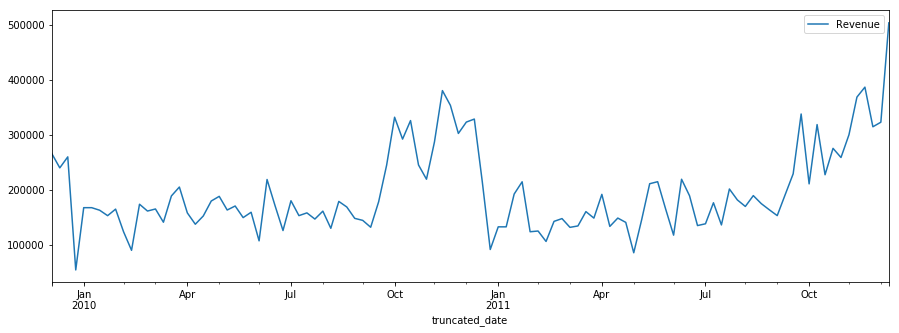

In [25]:
# Looks like there could be some seasonality, can deal with this later
tseries_weekly.plot(kind='line', figsize=(15,5))

In [26]:
tseries_weekly.index

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='truncated_date', length=106, freq='W-SUN')

In [27]:
# check montly deviations for various diffs
print(tseries_weekly.Revenue.std())
print(tseries_weekly.Revenue.diff().std()) # This one is the lowest-- single diff
print(tseries_weekly.Revenue.diff().diff().std())
print(tseries_weekly.Revenue.diff().diff().diff().std())

76769.96796102638
56220.19806920004
87522.51145951492
154234.79438483092


### Difference weekly data

In [28]:
tseries_weekly_diff = tseries_weekly.diff().dropna()
tseries_weekly_diff.head()

,Revenue
truncated_date,
2009-12-13,-25788.24
2009-12-20,19956.90
2009-12-27,-205283.73
2010-01-03,113039.00
2010-01-10,0.00


### Dicky fuller: Weekly diff data

In [29]:
# Dicky fuller as a function
# 0th element = test statistic, 1st element = p value, 4th = critical values

# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):# input is a time series col
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -8.721915e+00
p-value                 3.367590e-14
Lags Used               2.000000e+00
Observations Used       1.020000e+02
Critical Value (1%)    -3.496149e+00
Critical Value (5%)    -2.890321e+00
Critical Value (10%)   -2.582122e+00
dtype: float64


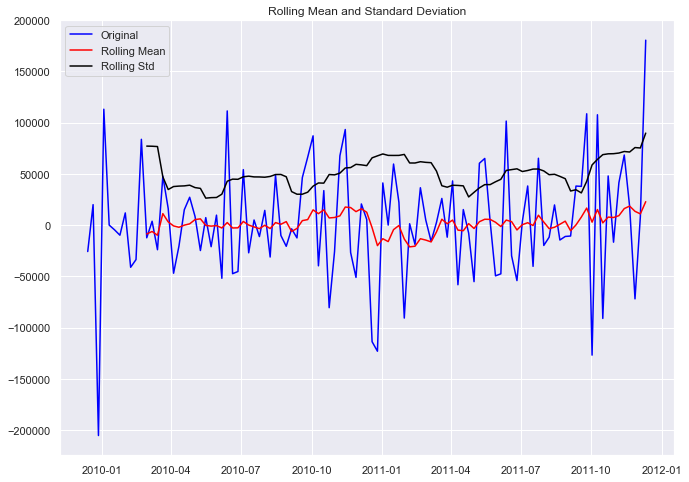

In [714]:
dftest(tseries_weekly_diff['Revenue'])
# Passes dicky fuller, but spikey

### Resample Montly

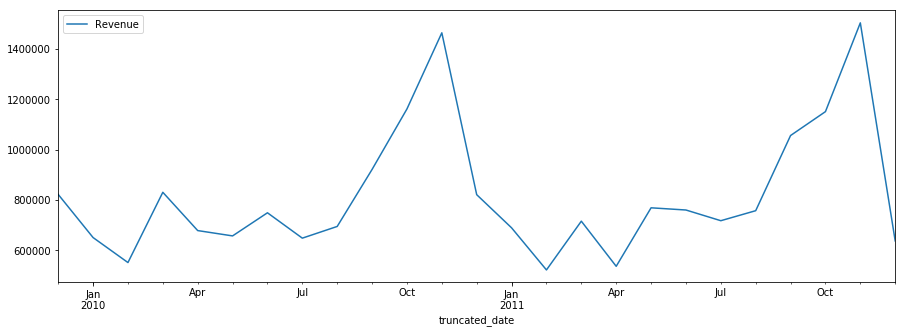

In [31]:
tseries_monthly = tseries.resample('M').sum()
tseries_monthly.plot(kind='line', figsize=(15,5))

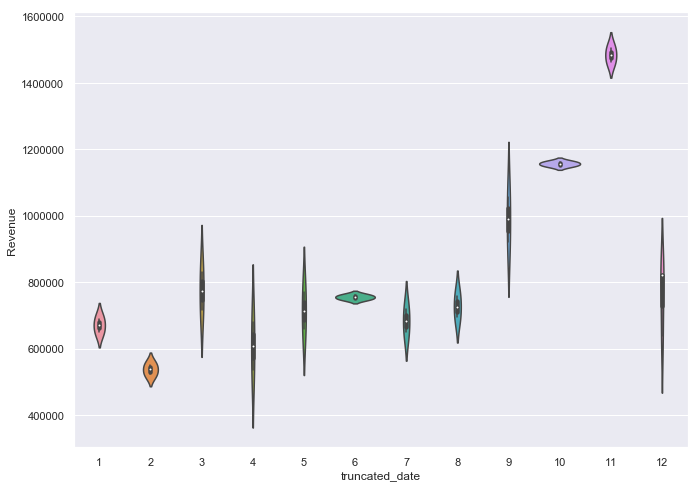

In [32]:
# Violinplot by months to determine variance and range
sns.set(rc={'figure.figsize':(11,8)})
sns.violinplot(x=tseries_monthly.index.month, y=tseries_monthly.Revenue)

# plots look off...

In [33]:
# check montly deviations for various diffs
print(tseries_monthly.Revenue.std()) # Lowest-- try without difs first
print(tseries_monthly.Revenue.diff().std())
print(tseries_monthly.Revenue.diff().diff().std())
print(tseries_monthly.Revenue.diff().diff().diff().std())

259977.07868483083
288815.39908649365
413364.9457859019
658132.6948245662


In [34]:
# Dicky fuller as a function
# 0th element = test statistic, 1st element = p value, 4th = critical values

# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):# input is a time series col
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=6).mean()
    rolstd = timeseries.rolling(window=6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic          -3.664491
p-value                  0.004641
Lags Used                9.000000
Observations Used       15.000000
Critical Value (1%)     -3.964443
Critical Value (5%)     -3.084908
Critical Value (10%)    -2.681814
dtype: float64


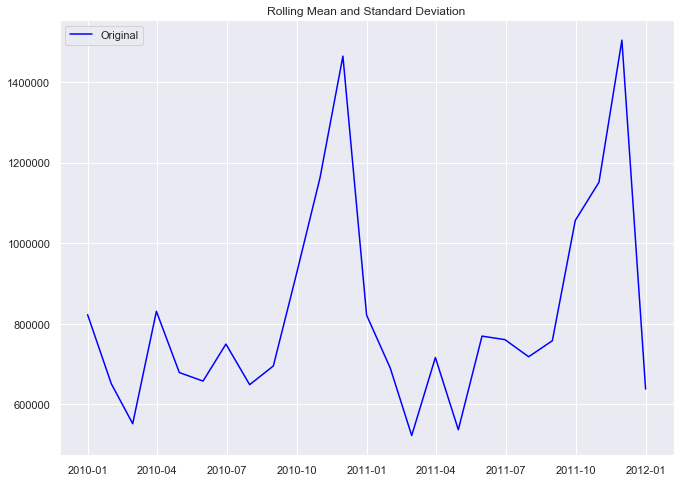

In [35]:
# Dicky fuller on montly NON differenced
dftest(tseries_monthly['Revenue'])

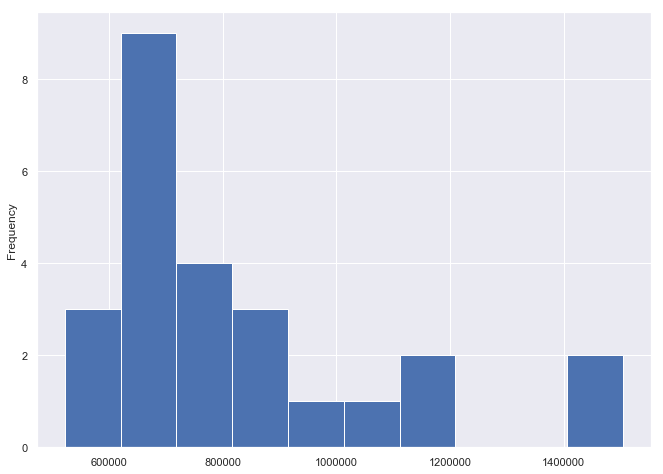

In [36]:
# Before moving forward so some final tests that the data is not stationary-- histogram to see if it has normal dist/ constant mean and stdv
tseries_monthly['Revenue'].plot(kind='hist')

# Begin models

### PACF + ACF Plots

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



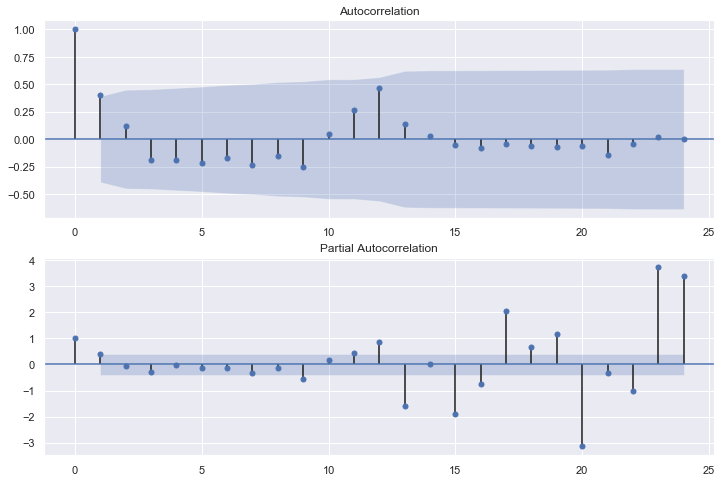

In [37]:
# DATA MUST BE STATIONARY BEFORE THESE PLOTS
# ALSO CAN GIVE INDICATION IF WE HAVE DIFFERENCED TOO MUCH

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(tseries_monthly['Revenue'], lags=24, zero=True, ax=ax1)

# Plot the PACF of df
plot_pacf(tseries_monthly['Revenue'], lags=24, zero=True, ax=ax2)

plt.show()

### PAC + ACF Plots with weekly difference resampled

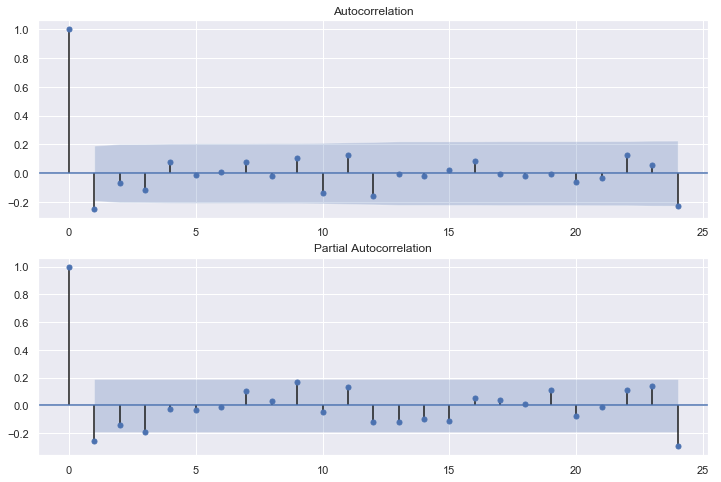

In [38]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(tseries_weekly_diff['Revenue'], lags=24, zero=True, ax=ax1)

# Plot the PACF of df
plot_pacf(tseries_weekly_diff['Revenue'], lags=24, zero=True, ax=ax2)

plt.show()



### Loop through pq for MONTHLY 

In [2]:
def find_best_pq(timeseries):
    '''Loops through various p and q values to fine the best AIC/BIC for the model'''
    order_aic_bic = []
    for p in range(0,3):
        # Loop over q values from 0-2
        for q in range(0,3):

            try:
                # create and fit ARMA(p,q) model
                model = SARIMAX(timeseries, order=(p,0,q))
                results = model.fit()

                # Print order and results
                #print(p, q, results.aic, results.bic)

            except:
                print(p, q, None, None)  
            
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
    
    # Put order_aic_bic into a df to find smallest values of aic/bic
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q','AIC', 'BIC'])

    # Print order_df in order of increasing AIC
    print(order_df.sort_values('AIC'))

In [40]:
find_best_pq(tseries_monthly['Revenue'])

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0 1 None None
   p  q         AIC         BIC
3  1  0  703.866063  706.303814
7  2  1  703.872544  708.748047
4  1  1  704.694368  708.350995
6  2  0  704.947832  708.604460
5  1  2  705.968201  710.843704
8  2  2  707.268579  713.362958
2  0  2  739.956666  743.613293
0  0  0  756.050921  757.269797
1  0  1  756.050921  757.269797


### Initial models AR, MA

In [41]:
model_0 = ARIMA(tseries_monthly['Revenue'], order=(1,0,0))
results_0 = model_0.fit()
print(results_0.summary())

                              ARMA Model Results                              
Dep. Variable:                Revenue   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -344.553
Method:                       css-mle   S.D. of innovations         233251.932
Date:                Thu, 05 Dec 2019   AIC                            695.106
Time:                        15:48:26   BIC                            698.763
Sample:                    12-31-2009   HQIC                           696.120
                         - 12-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.191e+05   7.47e+04     10.970      0.000    6.73e+05    9.65e+05
ar.L1.Revenue     0.3905      0.180      2.167      0.041       0.037       0.744
                                    Root

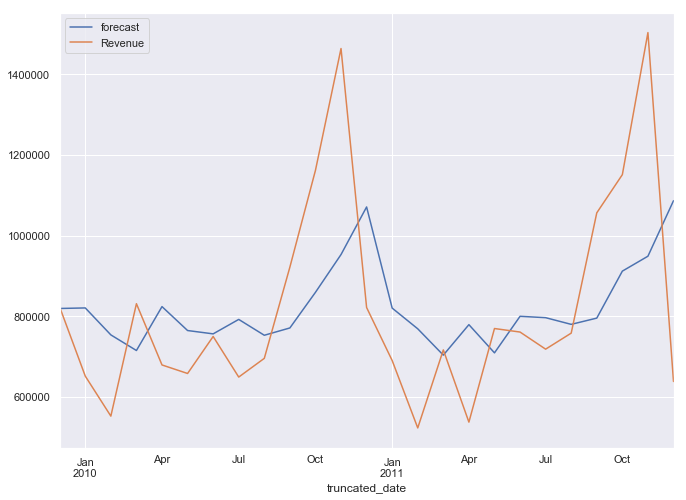

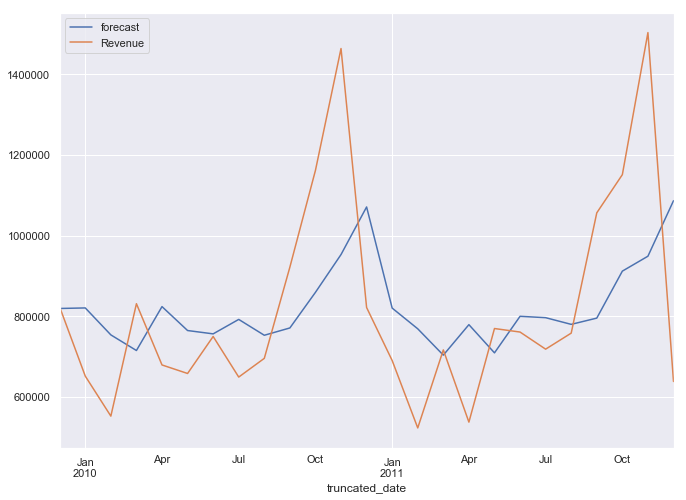

In [42]:
results_0.plot_predict()

                           Statespace Model Results                           
Dep. Variable:                Revenue   No. Observations:                   25
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -349.347
Date:                Thu, 05 Dec 2019   AIC                            704.694
Time:                        15:48:26   BIC                            708.351
Sample:                    12-31-2009   HQIC                           705.709
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9809      0.062     15.812      0.000       0.859       1.102
ma.L1         -0.4139      0.244     -1.694      0.090      -0.893       0.065
sigma2      8.035e+10   4.97e-13   1.62e+23      0.0

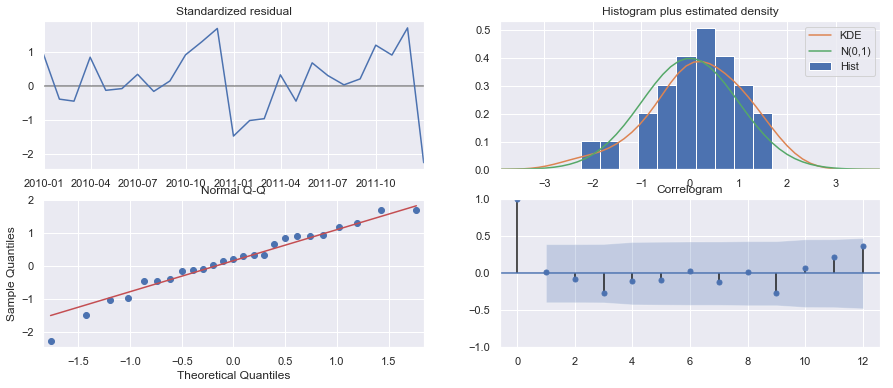

In [43]:
#model_1 = SARIMAX(tseries_monthly['Revenue'], order=(1,0,0), seasonal_order=(1,0,0,12), trend= 'ct')
model_1 = SARIMAX(tseries_monthly['Revenue'], order=(1,0,1))
results_1 = model_1.fit(disp = -1)
print(results_1.summary())
print(results_1.plot_diagnostics(lags=12,figsize=(15,6)))

In [49]:
# Look at residuals and MAE
model_1_resids = results_1.resid
mae_1 = np.mean(np.abs(model_1_resids))
print(mae_1)

235742.36542016058


In [139]:
model_2 = SARIMAX(tseries_monthly['Revenue'],
                  order=(1, 0, 1),
                  seasonal_order=(1, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility= False,
                  trend='ct')  #ct vs c?
results_2 = model_2.fit()
print(results_2.summary())

ValueError: maxlag should be < nobs

In [140]:
results_2.plot_diagnostics()

NameError: name 'results_2' is not defined

# Weekly differenced models

### Find best pq for weekly dif

In [52]:
find_best_pq(tseries_weekly_diff['Revenue'])

2 1 None None
   p  q          AIC          BIC
1  0  1  2587.342355  2592.650276
2  0  2  2587.345413  2595.307294
4  1  1  2587.858222  2595.820103
5  1  2  2589.247675  2599.863516
6  2  0  2590.039342  2598.001223
7  2  1  2590.039342  2598.001223
3  1  0  2590.486712  2595.794633
8  2  2  2591.262862  2604.532663
0  0  0  2595.920316  2598.574277


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



### ARIMA with WEEKLY differenced

In [53]:
model_weekly_diff = SARIMAX(tseries_weekly_diff['Revenue'], order=(0,0,1))
results_weekly_diff = model_weekly_diff.fit()
print(results_weekly_diff.summary())

                           Statespace Model Results                           
Dep. Variable:                Revenue   No. Observations:                  105
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1291.671
Date:                Thu, 05 Dec 2019   AIC                           2587.342
Time:                        15:48:56   BIC                           2592.650
Sample:                    12-13-2009   HQIC                          2589.493
                         - 12-11-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4248      0.077     -5.508      0.000      -0.576      -0.274
sigma2        2.5e+09    7.9e-12   3.16e+20      0.000     2.5e+09     2.5e+09
Ljung-Box (Q):                       49.71   Jarque-

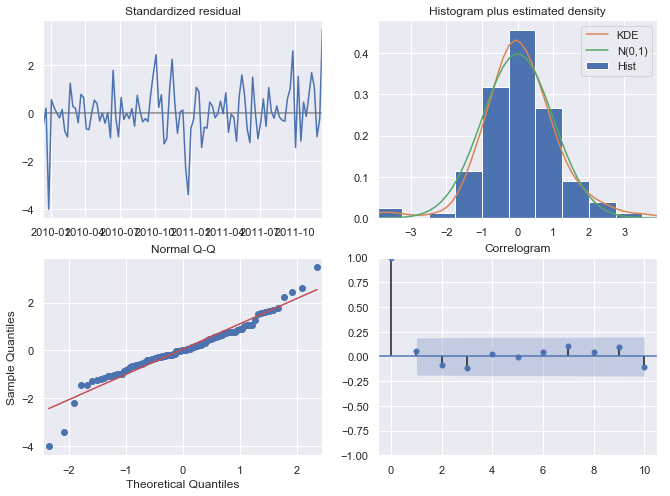

In [54]:
results_weekly_diff.plot_diagnostics();

### Decompose weekly sarima

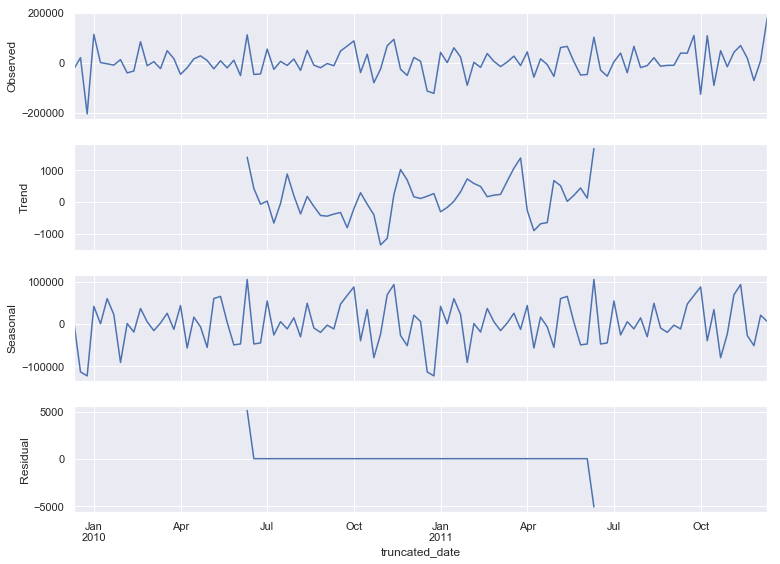

In [55]:
decomp_weekly = seasonal_decompose(x = tseries_weekly_diff['Revenue'])
decomp_weekly.plot();


In [56]:
# Same issue when decomposing weekly.. lots of NaN == not enough data
print(decomp_weekly.resid)
print(decomp_weekly.seasonal)
print(decomp_weekly.trend)

truncated_date
2009-12-13   NaN
2009-12-20   NaN
2009-12-27   NaN
2010-01-03   NaN
2010-01-10   NaN
              ..
2011-11-13   NaN
2011-11-20   NaN
2011-11-27   NaN
2011-12-04   NaN
2011-12-11   NaN
Freq: W-SUN, Name: Revenue, Length: 105, dtype: float64
truncated_date
2009-12-13      5343.356482
2009-12-20   -113956.550922
2009-12-27   -123326.963614
2010-01-03     41398.134463
2010-01-10       148.671482
                  ...      
2011-11-13     92993.032963
2011-11-20    -27810.524287
2011-11-27    -51730.220960
2011-12-04     20448.230424
2011-12-11      5343.356482
Freq: W-SUN, Name: Revenue, Length: 105, dtype: float64
truncated_date
2009-12-13   NaN
2009-12-20   NaN
2009-12-27   NaN
2010-01-03   NaN
2010-01-10   NaN
              ..
2011-11-13   NaN
2011-11-20   NaN
2011-11-27   NaN
2011-12-04   NaN
2011-12-11   NaN
Freq: W-SUN, Name: Revenue, Length: 105, dtype: float64


### Forecast weekly model

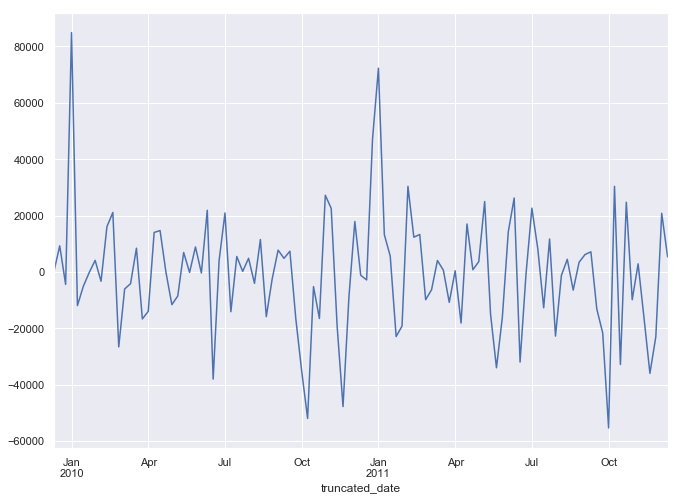

In [57]:
results_weekly_diff.predict().plot()
# What is this??

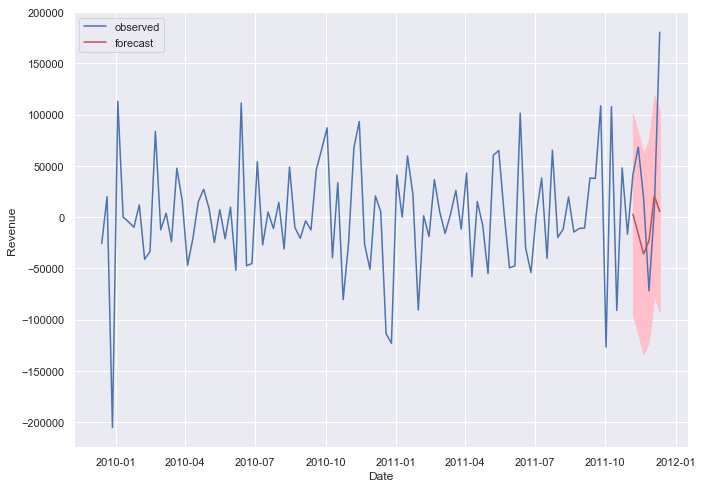

In [58]:
one_step_forecast_weekly = results_weekly_diff.get_prediction(start=-6) # Predictions over 4 months
mean_forecast_weekly = one_step_forecast_weekly.predicted_mean # mean of predictions

# Confidence intervals of the predictions + get lower/upper bounds
confidence_invervals_weekly = one_step_forecast_weekly.conf_int()
lower_limits_weekly = confidence_invervals_weekly.loc[:, 'lower Revenue']
upper_limits_weekly = confidence_invervals_weekly.loc[:, 'upper Revenue']

# Plot
plt.plot(tseries_weekly_diff.index, tseries_weekly_diff, label='observed')
plt.plot(mean_forecast_weekly.index, mean_forecast_weekly, color='r', label='forecast')
plt.fill_between(lower_limits_weekly.index, lower_limits_weekly, upper_limits_weekly, color='pink')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend();

# Examine seasonality + seasonal models

In [59]:
tseries_monthly['Revenue']

truncated_date
2009-12-31     822483.950
2010-01-31     651155.112
2010-02-28     551878.296
2010-03-31     830915.261
2010-04-30     678875.252
2010-05-31     657705.500
2010-06-30     749537.310
2010-07-31     648810.270
2010-08-31     695251.910
2010-09-30     921696.991
2010-10-31    1161902.220
2010-11-30    1464293.142
2010-12-31     821452.730
2011-01-31     689811.610
2011-02-28     522545.560
2011-03-31     716215.260
2011-04-30     536968.491
2011-05-31     769296.610
2011-06-30     760547.010
2011-07-31     718076.121
2011-08-31     757841.380
2011-09-30    1056435.192
2011-10-31    1151263.730
2011-11-30    1503866.780
2011-12-31     637808.330
Freq: M, Name: Revenue, dtype: float64

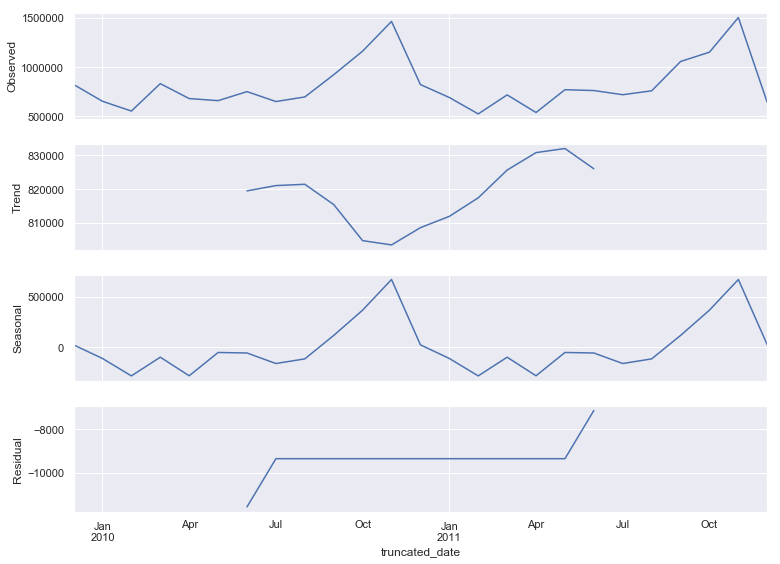

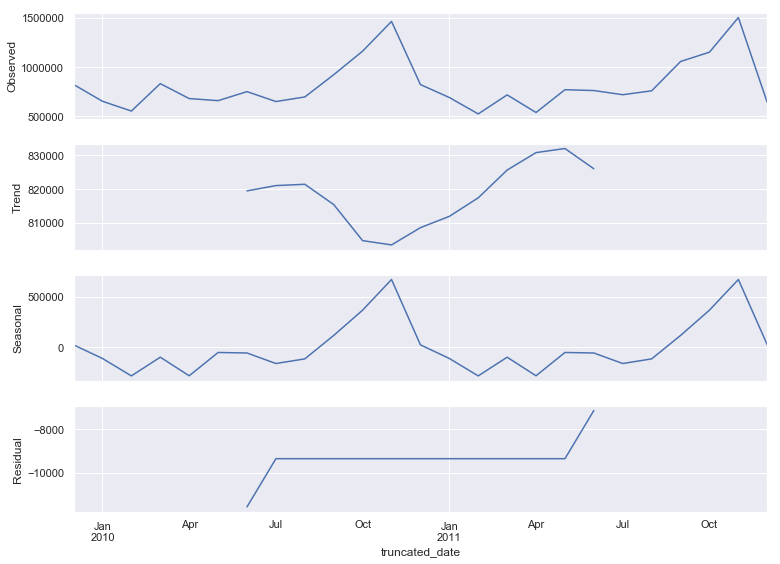

In [60]:
decomp = seasonal_decompose(x = tseries_monthly['Revenue'])
decomp.plot()

# In sample one-step ahead forecast
- For now ignoring seasonality to see if models can predict in sample.
- Probably won't be able to because seasonality isn't learned

In [138]:
results_2.predict().plot() # WHAT IS .PREDICT() EVEN DOING...

NameError: name 'results_2' is not defined

In [137]:
one_step_forecast = results_2.get_prediction(start=-6) # Predictions over 4 months
mean_forecast = one_step_forecast.predicted_mean # mean of predictions

# Confidence intervals of the predictions + get lower/upper bounds
confidence_invervals = one_step_forecast.conf_int()
lower_limits = confidence_invervals.loc[:, 'lower Revenue']
upper_limits = confidence_invervals.loc[:, 'upper Revenue']

# Plot
plt.plot(tseries_monthly.index, tseries_monthly, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend();

NameError: name 'results_2' is not defined

### Train test split forecast

In [59]:
# # Train test split
# tseries_monthly_train = tseries_monthly['2009-12-31':'2011-08-31']
# tseries_monthly_test = tseries_monthly['2011-08-31':]

# # Plot train test split 
# fig, ax = plt.subplots()
# tseries_monthly_train.plot(ax=ax)
# tseries_monthly_test.plot(ax=ax)

In [60]:
# This gives a model SARIMAX(2,1,1)(1,0,0,7)
model_3 = ARMA(tseries_monthly['Revenue'], order=(1,0))

# Deseasonal manually

In [74]:
# Deseasonal_1 is the manually deseasoned doc
deseason = pd.read_csv('/Users/alentersakyan/Downloads/Deseasonal_1.csv')

In [76]:
deseason['Month'] = pd.to_datetime(deseason['Month'])

In [78]:
deseason.set_index('Month',inplace=True)

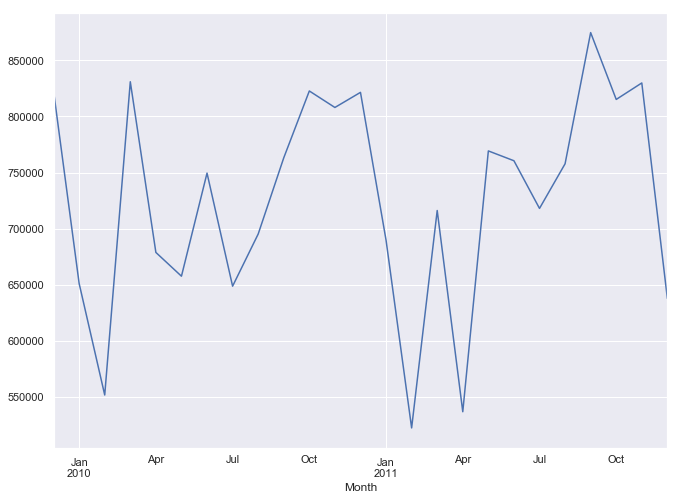

In [87]:
deseason['Deseasnonal Revenue'].plot()

### Find best pq for new deseasonal df

In [95]:
find_best_pq(deseason['Deseasnonal Revenue'])

0 2 None None
1 1 None None
2 1 None None
   p  q         AIC         BIC
5  1  2  660.586951  665.462455
8  2  2  662.830677  668.925056
6  2  0  663.784850  667.441478
7  2  1  663.784850  667.441478
3  1  0  666.456534  668.894286
4  1  1  666.456534  668.894286
1  0  1  733.952138  736.389890
2  0  2  733.952138  736.389890
0  0  0  748.089612  749.308488


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No fre

### Model 1

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



<bound method SARIMAXResults.summary of <statsmodels.tsa.statespace.sarimax.SARIMAXResults object at 0x1c2fbc3438>>
Figure(792x576)


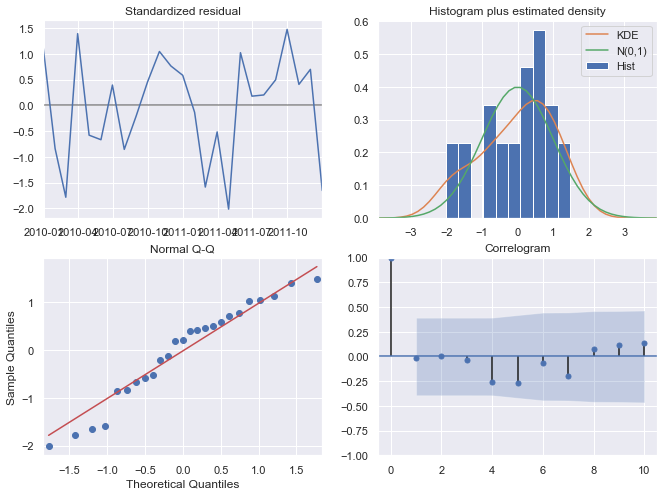

In [98]:
ARMA_deseasoned = SARIMAX(deseason['Deseasnonal Revenue'], order=(1,0,2), seasonal_order=(1,0,0,12), trend='ct')
results_ARMA_deseasoned = ARMA_deseasoned.fit()
print(results_ARMA_deseasoned.summary)
print(results_ARMA_deseasoned.plot_diagnostics())

### PAC + ACF deseasonal

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



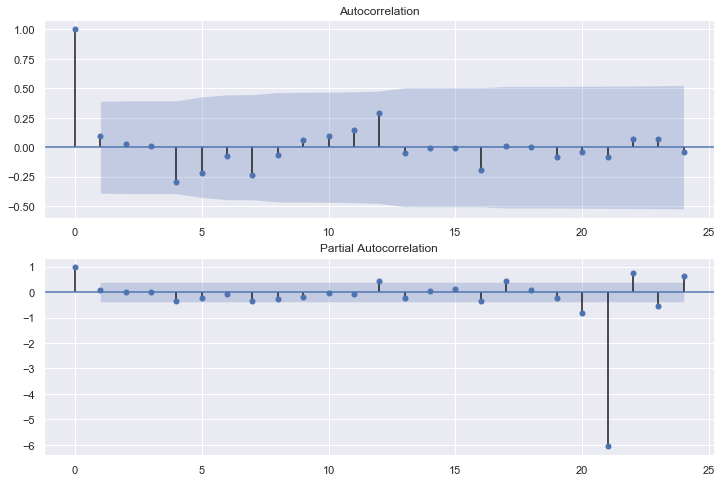

In [108]:
# DATA MUST BE STATIONARY BEFORE THESE PLOTS
# ALSO CAN GIVE INDICATION IF WE HAVE DIFFERENCED TOO MUCH

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(deseason['Deseasnonal Revenue'], lags=24, zero=True, ax=ax1)

# Plot the PACF of df
plot_pacf(deseason['Deseasnonal Revenue'], lags=24, zero=True, ax=ax2)

plt.show()

### Model 2

In [109]:
model_deseasoned = SARIMAX(deseason['Deseasnonal Revenue'], order=(1,0,2), seasonal_order=(1,0,0,12), trend='ct')

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



In [110]:
results_deseasoned = model_deseasoned.fit()

                                 Statespace Model Results                                 
Dep. Variable:                Deseasnonal Revenue   No. Observations:                   25
Model:             SARIMAX(1, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -319.728
Date:                            Thu, 05 Dec 2019   AIC                            653.455
Time:                                    16:06:02   BIC                            661.987
Sample:                                12-31-2009   HQIC                           655.822
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.321e+05      6.757   1.23e+05      0.000    8.32e+05    8.32e+05
drift        819.0236   3905.719   

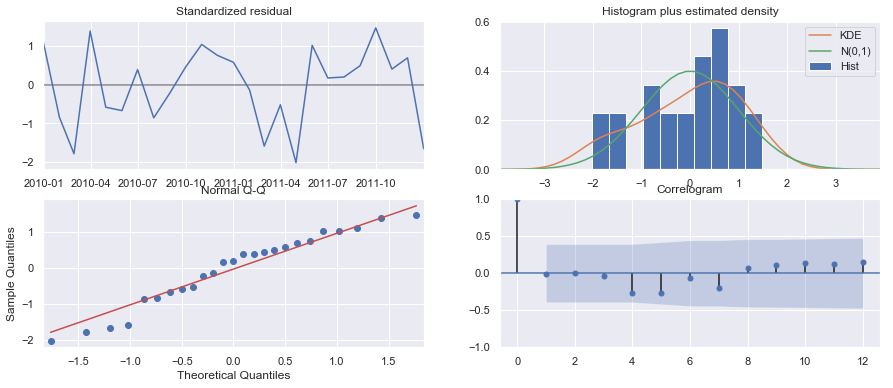

In [111]:
print(results_deseasoned.summary())
print(results_deseasoned.plot_diagnostics(lags=12, figsize=(15,6)))

# Deseasoned forecasts

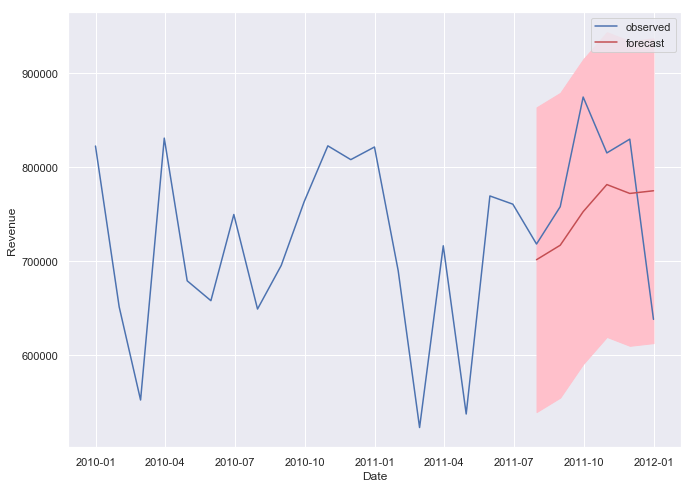

In [129]:
one_step_forecast_deseasonal = results_deseasoned.get_prediction(start=-6) # Predictions over 4 months
mean_forecast_deseasonal = one_step_forecast_deseasonal.predicted_mean # mean of predictions

# Confidence intervals of the predictions + get lower/upper bounds
confidence_invervals_deseasonal = one_step_forecast_deseasonal.conf_int()
lower_limits_deseasonal = confidence_invervals_deseasonal.loc[:, 'lower Deseasnonal Revenue']
upper_limits_deseasonal = confidence_invervals_deseasonal.loc[:, 'upper Deseasnonal Revenue']

# Plot
plt.plot(deseason['Deseasnonal Revenue'].index, deseason['Deseasnonal Revenue'], label='observed')
plt.plot(mean_forecast_deseasonal.index, mean_forecast_deseasonal, color='r', label='forecast')
plt.fill_between(lower_limits_deseasonal.index, lower_limits_deseasonal, upper_limits_deseasonal, color='pink')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend();

In [130]:
# Add back seasonality by multiplying back factors 1.4/1.8 for seasonal components
mean_forecast_deseasonal_reseasoned = mean_forecast_deseasonal.replace({mean_forecast_deseasonal[2]: mean_forecast_deseasonal[2]*1.2, \
                                  mean_forecast_deseasonal[3]: mean_forecast_deseasonal[2]*1.4,\
                                  mean_forecast_deseasonal[4]: mean_forecast_deseasonal[4]*1.8})

In [136]:
mean_forecast_deseasonal_reseasoned

2011-07-31    7.013698e+05
2011-08-31    7.167818e+05
2011-09-30    9.030442e+05
2011-10-31    1.053552e+06
2011-11-30    1.389549e+06
2011-12-31    7.748344e+05
Freq: M, dtype: float64

### Forecase Model 2 with season back in

In [814]:
one_step_forecast_deseasonal

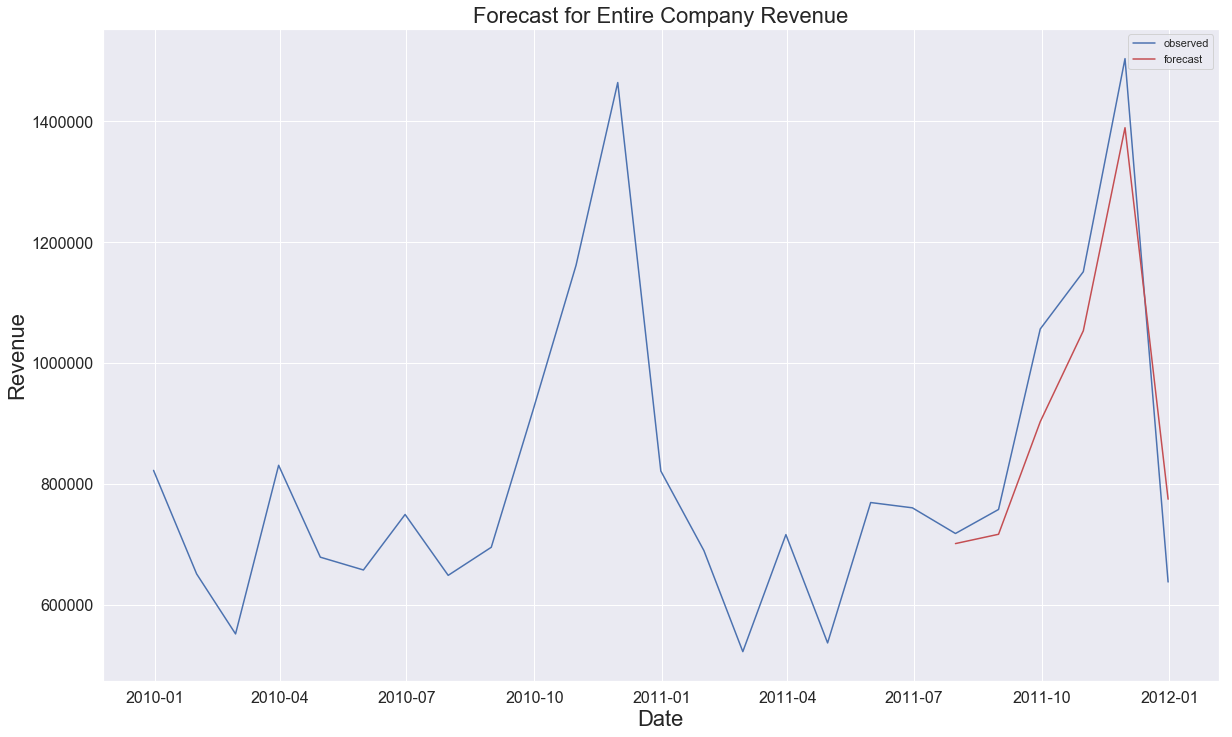

In [1032]:
one_step_forecast_deseasonal = results_deseasoned.get_prediction(start=-3) # Predictions over 4 months
#mean_forecast_deseasonal = one_step_forecast_deseasonal.predicted_mean # mean of predictions

# Confidence intervals don't apply anymore with this method of taking out and putting back seasonality
#confidence_invervals_deseasonal = one_step_forecast_deseasonal.conf_int()
#lower_limits_deseasonal = confidence_invervals_deseasonal.loc[:, 'lower Deseasnonal Revenue']
#upper_limits_deseasonal = confidence_invervals_deseasonal.loc[:, 'upper Deseasnonal Revenue']

plt.figure(figsize=(20,12))
# Plot Observed (raw 'Revenue' forecast)
plt.plot(tseries_monthly['Revenue'].index, tseries_monthly['Revenue'], label='observed')

# Plot Forecast-- deseasoned, then reseasoned data
plt.plot(mean_forecast_deseasonal_reseasoned.index, mean_forecast_deseasonal_reseasoned, color='r', label='forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('In-sample forecast for all customers')
plt.xlabel('Date', fontsize=22)
plt.xticks(fontsize=16)
plt.ylabel('Revenue', fontsize=22)
plt.yticks(fontsize=16)
plt.title('Forecast for Entire Company Revenue',fontsize=22)
plt.savefig('Whole_df_timeseries.png');

# Prep for cluster group time series

### Open pickled / cleaned df that clustering was done on

In [580]:
with open('df_cleaned.pickle','rb') as read_file:
    df_ts = pickle.load(read_file)

In [581]:
df_ts.shape

(805620, 12)

In [626]:
# # To load pickle back in
# with open('kmeans_cohort_q123.pickle','rb') as read_file:
#     kmeans_cohort_q123 = pickle.load(read_file)

In [583]:
# To load pickle back in
with open('kmeans_cohort_q1234.pickle','rb') as read_file:
    kmeans_cohort_q1234 = pickle.load(read_file)

In [584]:
# cluster0 = kmeans_cohort_q123[kmeans_cohort_q123.cluster_no == 0]
# cluster1 = kmeans_cohort_q123[kmeans_cohort_q123.cluster_no == 1]
# cluster2 = kmeans_cohort_q123[kmeans_cohort_q123.cluster_no == 2]
# cluster3 = kmeans_cohort_q123[kmeans_cohort_q123.cluster_no == 3]

# print(cluster0.shape, cluster1.shape, cluster2.shape, cluster3.shape)

In [585]:
kmeans_cohort_q1234.cluster_no.value_counts()

1    663
0    391
2    146
Name: cluster_no, dtype: int64

In [609]:
# These orders match my clustering plots, but do not match the numbers from the yellowbrick plots!!!!!

cluster0 = kmeans_cohort_q1234[kmeans_cohort_q1234.cluster_no == 0]
cluster1 = kmeans_cohort_q1234[kmeans_cohort_q1234.cluster_no == 1]
cluster2 = kmeans_cohort_q1234[kmeans_cohort_q1234.cluster_no == 2]

print(cluster0.shape, cluster1.shape, cluster2.shape)

(391, 4) (663, 4) (146, 4)


### Recreate df_cohort filter

In [588]:
df_cohort_q1 = df_cohort[(df_cohort.InvoiceDate.dt.quarter == 1) & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q12 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 2) & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q123 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 3) & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q1234 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 4) & (df_cohort['InvoiceDate'].dt.year == 2010)]

print(df_cohort_q1.shape, df_cohort_q12.shape, df_cohort_q123.shape, df_cohort_q1234.shape)

(39426, 13) (63863, 13) (87851, 13) (116994, 13)


In [630]:
df_cohort_q1234.InvoiceDate.describe() # At this point it's only 2010, each cumulative Q is ok here

count                  116994
unique                   5226
top       2010-03-07 15:34:00
freq                      270
first     2010-01-04 10:43:00
last      2010-12-23 14:35:00
Name: InvoiceDate, dtype: object

In [631]:
df_cohort_q1.InvoiceDate.describe()

count                   39426
unique                   1748
top       2010-03-07 15:34:00
freq                      270
first     2010-01-04 10:43:00
last      2010-03-31 15:42:00
Name: InvoiceDate, dtype: object

In [632]:
# df_cohort = df_ts[(df_ts['CohortMonth'] >= '2010-01-01') & (df_ts['CohortMonth'] <= '2010-03-01')]

In [636]:
df_cohort_q1234.shape

(116994, 13)

In [637]:
df_cohort_q1234['Customer ID'].nunique()

1202

### Create dictionary to map Customer ID with cluster number from kmeans

In [592]:
# clusters = [cluster0, cluster1, cluster2]

# dict_map = {}

# for idx, cluster in enumerate(clusters): # enumerate cluster no
#     temp_dict = {value: str(idx) for value in cluster.index.values}
#     dict_map.update(temp_dict)        

In [611]:
missing_cust_ids = set()

def map_to_id(cust_id):
    try:
        return int(dict_map[cust_id])  
    except:
        missing_cust_ids.add(cust_id)
        return np.nan

In [638]:
df_cohort_q1234['CLUSTER'] = df_cohort_q1234['Customer ID'].apply(map_to_id)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [639]:
missing_cust_ids

{14103.0, 14827.0}

In [641]:
df_cohort_q1234.CLUSTER

65        1.0
197       2.0
198       2.0
199       2.0
200       2.0
         ... 
525391    2.0
525392    2.0
525393    2.0
525394    2.0
525395    2.0
Name: CLUSTER, Length: 116994, dtype: float64

In [642]:
print(df_cohort_q1234['Customer ID'][df_cohort_q1234.CLUSTER == 0.0].nunique())
print(df_cohort_q1234['Customer ID'][df_cohort_q1234.CLUSTER == 1.0].nunique())
print(df_cohort_q1234['Customer ID'][df_cohort_q1234.CLUSTER == 2.0].nunique())

391
663
146


In [646]:
df_cohort_q1234['InvoiceDate'][df_cohort_q1234.CLUSTER == 0.0].describe()

count                    9753
unique                    586
top       2010-03-03 13:57:00
freq                      139
first     2010-01-04 10:43:00
last      2010-09-07 16:21:00
Name: InvoiceDate, dtype: object

# Time series on cluster groups: 1+2

In [682]:
df_cohort_ts = df_cohort_q1234.set_index('InvoiceDate')
df_cohort_ts.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,InvoiceMonth,CohortMonth,Revenue,CohortIndex,CLUSTER
InvoiceDate,,,,,,,,,,,,
2010-12-01 09:09:00,536374,21258,VICTORIAN SEWING BOX LARGE,32,10.95,15100.0,United Kingdom,2010-12-01,2010-01-01,350.4,12,1.0
2010-12-01 10:03:00,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,8.50,12431.0,Australia,2010-12-01,2010-01-01,51.0,12,2.0
2010-12-01 10:03:00,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,4.95,12431.0,Australia,2010-12-01,2010-01-01,39.6,12,2.0
2010-12-01 10:03:00,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,1.25,12431.0,Australia,2010-12-01,2010-01-01,15.0,12,2.0
2010-12-01 10:03:00,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,5.45,12431.0,Australia,2010-12-01,2010-01-01,32.7,12,2.0


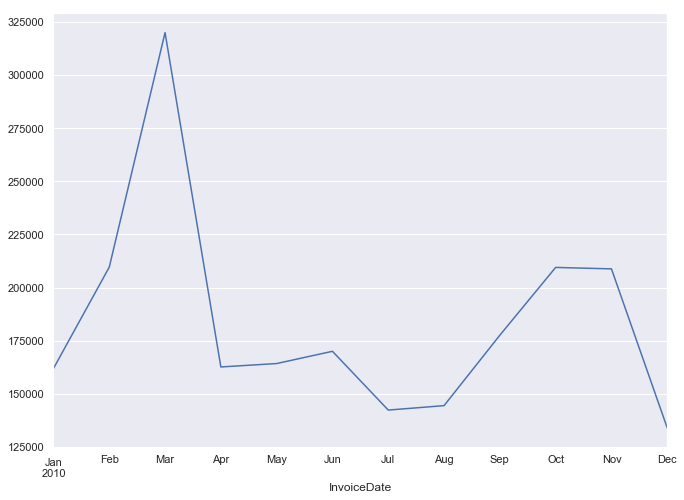

In [684]:
# Whole revenue plot for Cohort
cohort_ts_montly = df_cohort_ts['Revenue'].resample('M').sum()
cohort_ts_montly.plot();

In [605]:
# cluster_0_ts = df_cohort[df_cohort.CLUSTER == 0].set_index('InvoiceDate').resample('M')['Revenue'].sum()
# cluster_1_ts = df_cohort[df_cohort.CLUSTER == 1].set_index('InvoiceDate').resample('M')['Revenue'].sum()
# cluster_2_ts = df_cohort[df_cohort.CLUSTER == 2].set_index('InvoiceDate').resample('M')['Revenue'].sum()
# cluster_3_ts = df_cohort[df_cohort.CLUSTER == 3].set_index('InvoiceDate').resample('M')['Revenue'].sum()

In [743]:
cluster_0_ts = df_cohort_q1234[df_cohort_q1234.CLUSTER == 0].set_index('InvoiceDate').resample('W')['Revenue'].sum()
cluster_1_ts = df_cohort_q1234[df_cohort_q1234.CLUSTER == 1].set_index('InvoiceDate').resample('W')['Revenue'].sum()
cluster_2_ts = df_cohort_q1234[df_cohort_q1234.CLUSTER == 2].set_index('InvoiceDate').resample('W')['Revenue'].sum()

In [981]:
df_cohort_q1234.InvoiceDate.describe()

count                  116994
unique                   5226
top       2010-03-07 15:34:00
freq                      270
first     2010-01-04 10:43:00
last      2010-12-23 14:35:00
Name: InvoiceDate, dtype: object

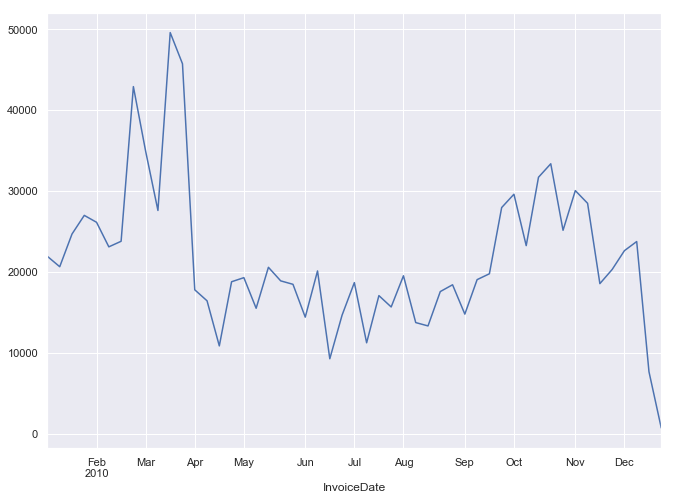

In [748]:
cluster_1_ts.plot()

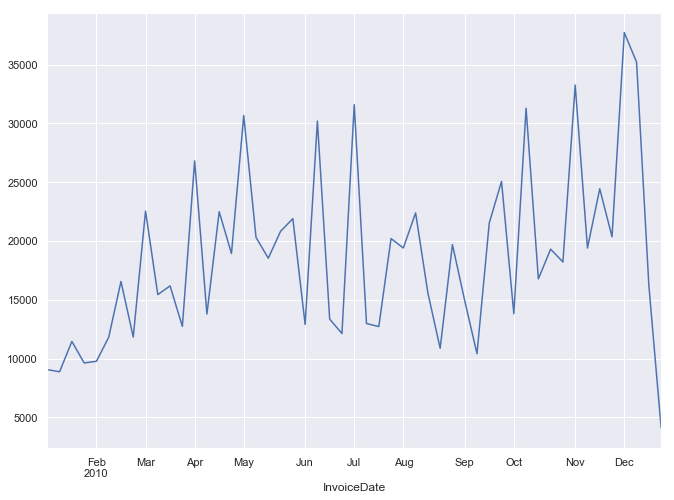

In [749]:
cluster_2_ts.plot() # check scale when making comparisons-- but trend is dif either way

In [750]:
print(cluster_0_ts.sum())
print(cluster_1_ts.sum())
print(cluster_2_ts.sum())

154399.79300000003
1104201.7620000022
946145.5330000013


In [751]:
# check montly deviations for various diffs
print(cluster_1_ts.std()) 
print(cluster_1_ts.diff().std()) # Probably 1 diff needed
print(cluster_1_ts.diff().diff().std())
print(cluster_1_ts.diff().diff().diff().std())

9051.507503713072
7856.056121543649
12046.22019004134
20560.047479474775


In [753]:
# check montly deviations for various diffs
print(cluster_2_ts.std()) # Probably 0 diff needed
print(cluster_2_ts.diff().std())
print(cluster_2_ts.diff().diff().std())
print(cluster_2_ts.diff().diff().diff().std())

7500.861606019984
9744.001301175647
16860.45670174521
31256.34465813685


### CLUSTER 1: DickyFuller + Differencing

In [759]:
cluster_1_ts_diff = cluster_1_ts.diff().dropna()

Test Statistic         -8.007920e+00
p-value                 2.241603e-12
Lags Used               0.000000e+00
Observations Used       4.900000e+01
Critical Value (1%)    -3.571472e+00
Critical Value (5%)    -2.922629e+00
Critical Value (10%)   -2.599336e+00
dtype: float64


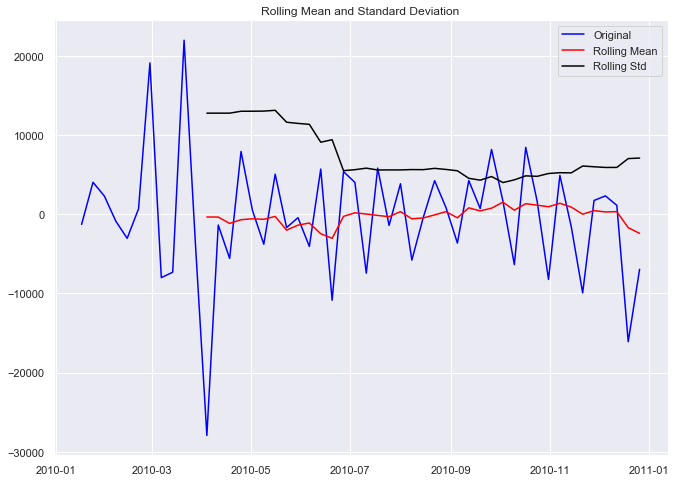

In [774]:
dftest(cluster_1_ts_diff)

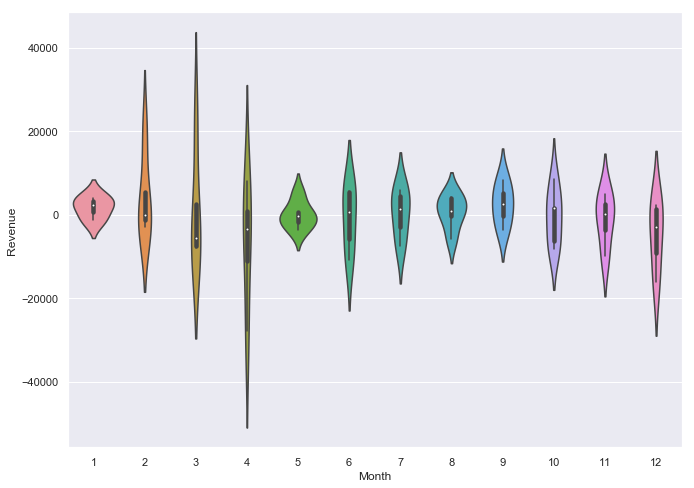

In [817]:
# violinplot months to determine variance and range
#sns.set()
sns.violinplot(x=cluster_1_ts_diff.index.month, y=cluster_1_ts_diff)
plt.xlabel("Month")
plt.ylabel("Revenue");

### Cluster 1-- pacf/acf plots


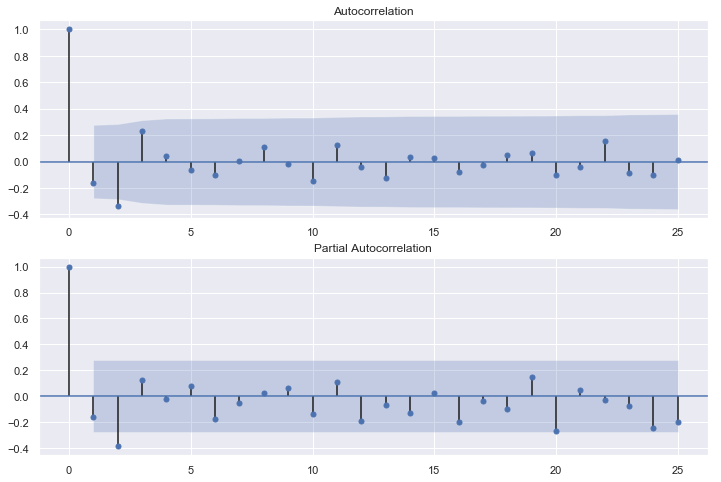

In [762]:
# DATA MUST BE STATIONARY BEFORE THESE PLOTS
# ALSO CAN GIVE INDICATION IF WE HAVE DIFFERENCED TOO MUCH

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(cluster_1_ts_diff, lags=25, zero=True, ax=ax1)

# Plot the PACF of df
plot_pacf(cluster_1_ts_diff, lags=25, zero=True, ax=ax2)

plt.show();

### Cluster 2: Dicky Fuller

Test Statistic         -5.948319e+00
p-value                 2.177300e-07
Lags Used               0.000000e+00
Observations Used       5.000000e+01
Critical Value (1%)    -3.568486e+00
Critical Value (5%)    -2.921360e+00
Critical Value (10%)   -2.598662e+00
dtype: float64


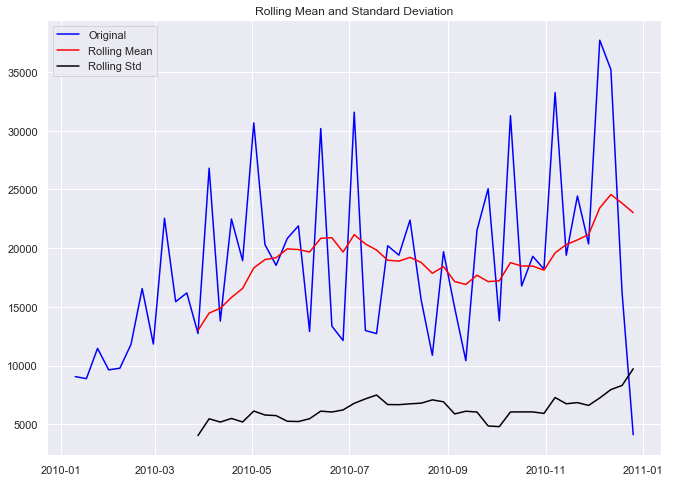

In [770]:
dftest(cluster_2_ts)

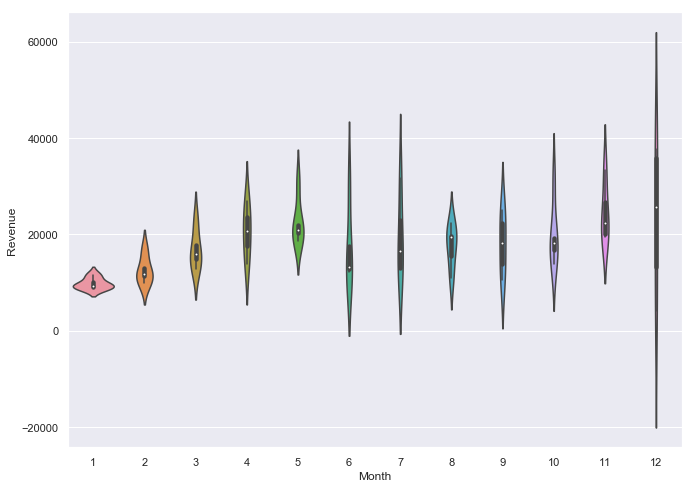

In [818]:
# violinplot months to determine variance and range
#sns.set()
sns.violinplot(x=cluster_2_ts.index.month, y=cluster_2_ts)
plt.xlabel("Month")
plt.ylabel("Revenue");

### CLUSTER 2- pacf/acf plots

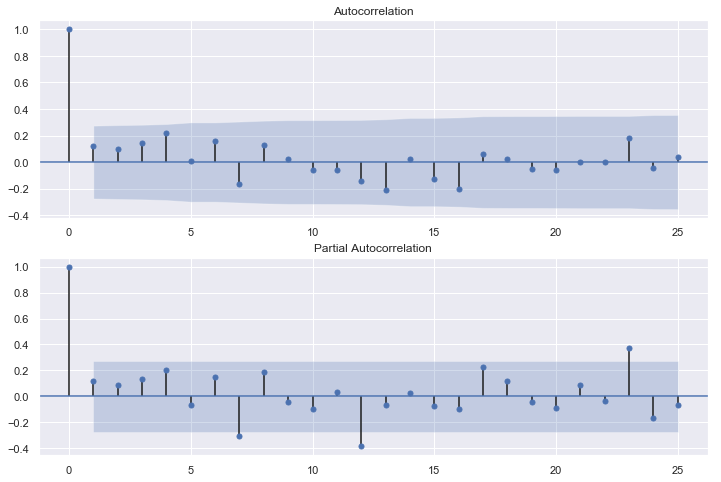

In [773]:
# DATA MUST BE STATIONARY BEFORE THESE PLOTS
# ALSO CAN GIVE INDICATION IF WE HAVE DIFFERENCED TOO MUCH

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(cluster_2_ts, lags=25, zero=True, ax=ax1)

# Plot the PACF of df
plot_pacf(cluster_2_ts, lags=25, zero=True, ax=ax2)

plt.show();

## Find best pq for each cluster

### Cluster 1

In [775]:
find_best_pq(cluster_1_ts_diff)

   p  q          AIC          BIC
6  2  0  1034.397096  1040.133165
5  1  2  1035.070349  1042.718441
2  0  2  1035.644591  1041.380660
7  2  1  1035.965661  1043.613753
8  2  2  1036.883076  1046.443191
4  1  1  1038.076416  1043.812485
1  0  1  1039.126502  1042.950548
0  0  0  1039.936267  1041.848290
3  1  0  1040.709483  1044.533529


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



### Cluster 2

In [779]:
find_best_pq(cluster_2_ts)

1 1 None None
1 2 None None
2 1 None None
2 2 None None
   p  q          AIC          BIC
6  2  0  1072.555603  1078.351080
7  2  1  1072.555603  1078.351080
8  2  2  1072.555603  1078.351080
3  1  0  1082.114073  1085.977724
4  1  1  1082.114073  1085.977724
5  1  2  1082.114073  1085.977724
2  0  2  1112.419176  1118.214653
1  0  1  1127.308248  1131.171899
0  0  0  1156.802185  1158.734011


## Model

#### Cluster 1

In [875]:
model_cluster1_diff = SARIMAX(cluster_1_ts_diff, order=(2,0,0))
results_cluster1_diff = model_cluster1_diff.fit()
print(results_cluster1_diff.summary())

                           Statespace Model Results                           
Dep. Variable:                Revenue   No. Observations:                   50
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -514.199
Date:                Tue, 10 Dec 2019   AIC                           1034.397
Time:                        09:28:51   BIC                           1040.133
Sample:                    01-17-2010   HQIC                          1036.581
                         - 12-26-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2365      0.136     -1.741      0.082      -0.503       0.030
ar.L2         -0.4077      0.076     -5.394      0.000      -0.556      -0.260
sigma2      5.148e+07    2.7e-10    1.9e+17      0.0

In [973]:
#trial
model_cluster1_diff = SARIMAX(np.log(cluster_1_ts), 
                         order=(0,1,1), 
                         seasonal_order = (0, 1, 0, 12), 
                         trend = [0,0,0,0])
results_cluster1_diff = model_cluster1_diff.fit()
print(results_cluster1_diff.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Revenue   No. Observations:                   51
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 12)   Log Likelihood                 -37.222
Date:                            Tue, 10 Dec 2019   AIC                             78.444
Time:                                    11:20:35   BIC                             81.719
Sample:                                01-10-2010   HQIC                            79.610
                                     - 12-26-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0499      0.153      0.326      0.745      -0.250       0.350
sigma2         0.4152      0.080   

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



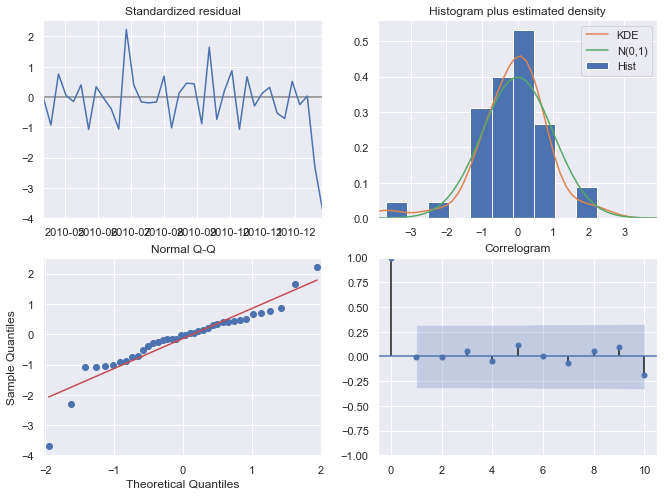

In [974]:
results_cluster1_diff.plot_diagnostics();

In [983]:
#trial
model_cluster1_diff = SARIMAX(np.log(cluster_1_ts), 
                         order=(0,1,1),
                         trend = [0,0,0,0])
results_cluster1_diff = model_cluster1_diff.fit()
print(results_cluster1_diff.summary())

                           Statespace Model Results                           
Dep. Variable:                Revenue   No. Observations:                   51
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -34.477
Date:                Tue, 10 Dec 2019   AIC                             72.954
Time:                        15:56:19   BIC                             76.779
Sample:                    01-10-2010   HQIC                            74.411
                         - 12-26-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2107      0.168      1.255      0.209      -0.118       0.540
sigma2         0.2323      0.043      5.349      0.000       0.147       0.317
Ljung-Box (Q):                       30.59   Jarque-

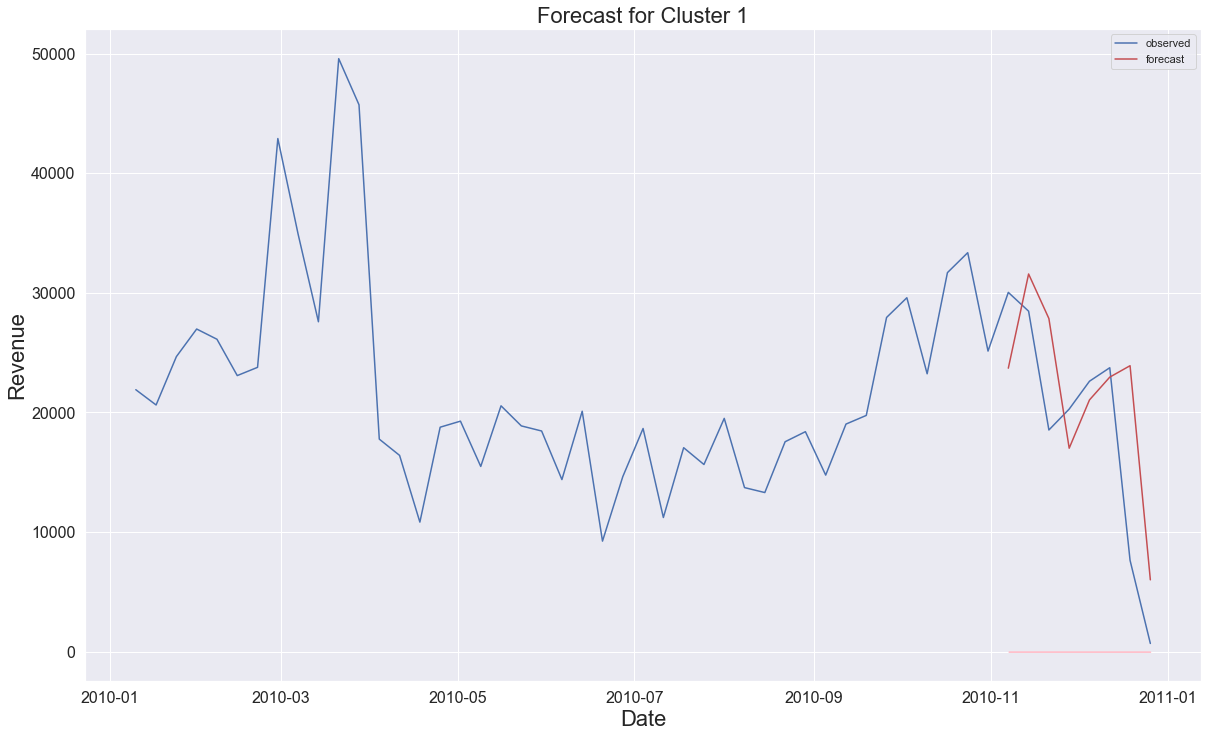

In [1020]:
onestep_cluster1 = results_cluster1_diff.get_prediction(start=-8) # Predictions over 4 months
mean_forecast_cluster1 = onestep_cluster1.predicted_mean # mean of predictions

# Confidence intervals of the predictions + get lower/upper bounds
CI_cluster1 = onestep_cluster1.conf_int()
lower_CI = CI_cluster1.loc[:, 'lower Revenue']
upper_CI = CI_cluster1.loc[:, 'upper Revenue']

# Plot
plt.figure(figsize=(20,12))
plt.plot(cluster_1_ts.index, cluster_1_ts, label='observed')
plt.plot(mean_forecast_cluster1.index, np.exp(mean_forecast_cluster1), color='r', label='forecast')
plt.fill_between(lower_CI.index, lower_CI, upper_CI, color='pink')
plt.xlabel('Date', fontsize=22)
plt.xticks(fontsize=16)
plt.ylabel('Revenue', fontsize=22)
plt.yticks(fontsize=16)
plt.title('Forecast for Cluster 1',fontsize=22)
plt.legend()
plt.savefig('Cluster1_timeseries.png')
# plt.figure(figsize=(15,12));

In [878]:
# MAE for residuals
mae_cluster1 = np.mean(np.abs(results_cluster1_diff.resid))

# Print mean absolute error
print(mae_cluster1)

5001.152656207478


#### Cluster 2

In [935]:
cluster_2_ts

InvoiceDate
2010-01-10     9058.110
2010-01-17     8882.230
2010-01-24    11460.730
2010-01-31     9630.770
2010-02-07     9770.610
2010-02-14    11809.910
2010-02-21    16559.031
2010-02-28    11830.640
2010-03-07    22543.660
2010-03-14    15438.750
2010-03-21    16183.350
2010-03-28    12729.570
2010-04-04    26809.930
2010-04-11    13782.790
2010-04-18    22485.560
2010-04-25    18930.990
2010-05-02    30669.221
2010-05-09    20304.360
2010-05-16    18533.400
2010-05-23    20820.930
2010-05-30    21895.990
2010-06-06    12903.390
2010-06-13    30190.760
2010-06-20    13354.400
2010-06-27    12132.770
2010-07-04    31582.070
2010-07-11    12983.430
2010-07-18    12719.610
2010-07-25    20206.560
2010-08-01    19401.180
2010-08-08    22387.090
2010-08-15    15580.150
2010-08-22    10872.810
2010-08-29    19696.100
2010-09-05    14925.880
2010-09-12    10414.280
2010-09-19    21525.831
2010-09-26    25060.980
2010-10-03    13809.790
2010-10-10    31280.710
2010-10-17    16776.620
2010

In [966]:
model_cluster2 = SARIMAX(np.log(cluster_2_ts), 
                         order=(0,1,1), 
                         seasonal_order = (0, 1, 0, 12), 
                         trend = [0,0,0,0])
results_cluster2 = model_cluster2.fit()
print(results_cluster2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Revenue   No. Observations:                   51
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 12)   Log Likelihood                 -33.542
Date:                            Tue, 10 Dec 2019   AIC                             71.084
Time:                                    11:15:43   BIC                             74.360
Sample:                                01-10-2010   HQIC                            72.250
                                     - 12-26-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7471      0.140     -5.349      0.000      -1.021      -0.473
sigma2         0.3349      0.082   

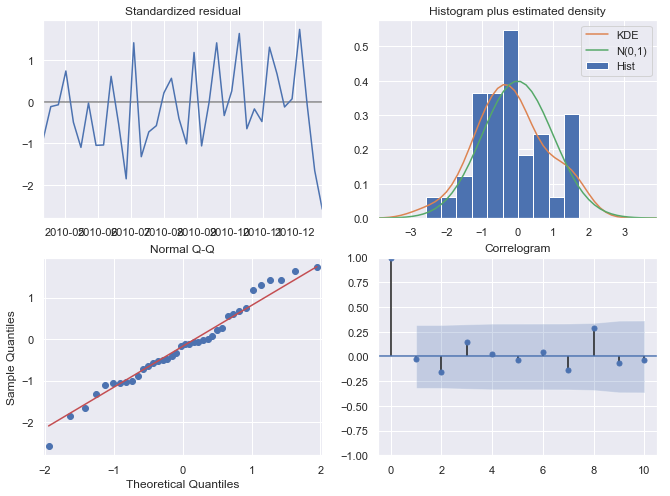

In [967]:
results_cluster2.plot_diagnostics();

In [971]:
mean_forecast_cluster2.index

DatetimeIndex(['2010-10-10', '2010-10-17', '2010-10-24', '2010-10-31',
               '2010-11-07', '2010-11-14', '2010-11-21', '2010-11-28',
               '2010-12-05', '2010-12-12', '2010-12-19', '2010-12-26'],
              dtype='datetime64[ns]', name='InvoiceDate', freq='W-SUN')

In [972]:
cluster_2_ts.index

DatetimeIndex(['2010-01-10', '2010-01-17', '2010-01-24', '2010-01-31',
               '2010-02-07', '2010-02-14', '2010-02-21', '2010-02-28',
               '2010-03-07', '2010-03-14', '2010-03-21', '2010-03-28',
               '2010-04-04', '2010-04-11', '2010-04-18', '2010-04-25',
               '2010-05-02', '2010-05-09', '2010-05-16', '2010-05-23',
               '2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01', '2010-08-08', '2010-08-15',
               '2010-08-22', '2010-08-29', '2010-09-05', '2010-09-12',
               '2010-09-19', '2010-09-26', '2010-10-03', '2010-10-10',
               '2010-10-17', '2010-10-24', '2010-10-31', '2010-11-07',
               '2010-11-14', '2010-11-21', '2010-11-28', '2010-12-05',
               '2010-12-12', '2010-12-19', '2010-12-26'],
              dtype='datetime64[ns]', name='InvoiceDate', freq='W-SUN')

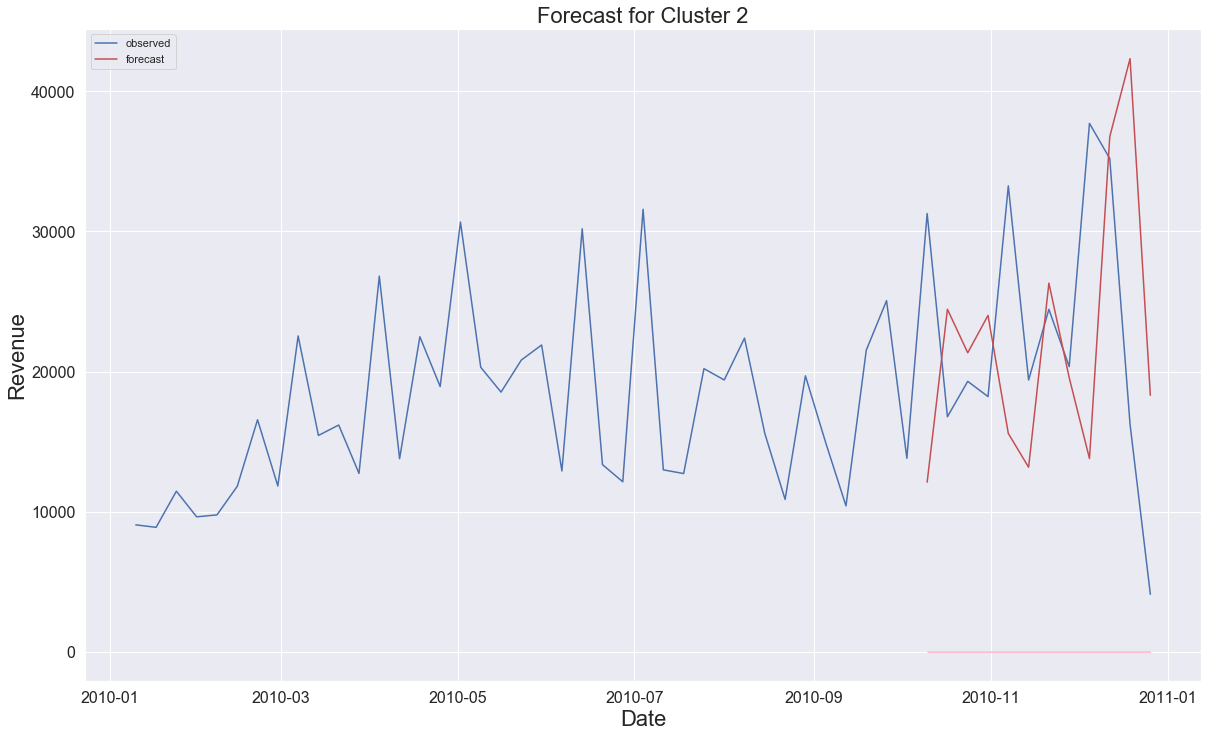

In [1022]:
onestep_cluster2 = results_cluster2.get_prediction(start=-12) # Predictions over 4 months
mean_forecast_cluster2 = onestep_cluster2.predicted_mean # mean of predictions

# Confidence intervals of the predictions + get lower/upper bounds
CI_cluster2 = onestep_cluster2.conf_int()
lower_CI = CI_cluster2.loc[:, 'lower Revenue']
upper_CI = CI_cluster2.loc[:, 'upper Revenue']

# Plot
plt.figure(figsize=(20,12))
plt.plot(cluster_2_ts.index, cluster_2_ts, label='observed')
plt.plot(mean_forecast_cluster2.index, np.exp(mean_forecast_cluster2), color='r', label='forecast')
plt.fill_between(lower_CI.index, lower_CI, upper_CI, color='pink')
plt.legend()
plt.xlabel('Date', fontsize=22)
plt.xticks(fontsize=16)
plt.ylabel('Revenue', fontsize=22)
plt.yticks(fontsize=16)
plt.title('Forecast for Cluster 2',fontsize=22)
plt.savefig('Cluster2_timeseries.png')

In [970]:
# MAE for residuals
mae_cluster2 = np.mean(np.abs(results_cluster2.resid))

# Print mean absolute error
print(mae_cluster2)

0.651037692245359


# Exponential smoothing models

In [ ]:
SimpleExpSmoothing()

In [911]:
fcast1

2011-01-02    21122.613231
2011-01-09    21122.613231
2011-01-16    21122.613231
2011-01-23    21122.613231
Freq: W-SUN, dtype: float64

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



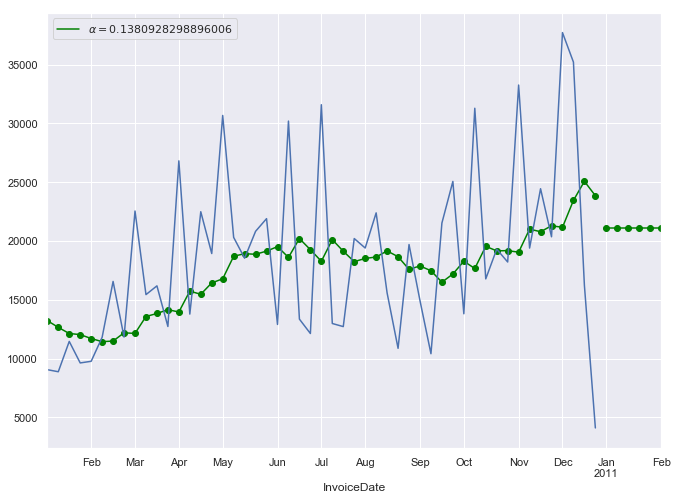

In [917]:
# Alpha being set automatically here by statsmodels
fit1 = SimpleExpSmoothing(cluster_2_ts).fit()
fcast1 = fit1.forecast(6).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])

# plot
fcast1.plot(marker='o', color='green', legend=True)
fit1.fittedvalues.plot(marker='o', color='green')

cluster_2_ts.plot()

plt.show()

# Halts

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



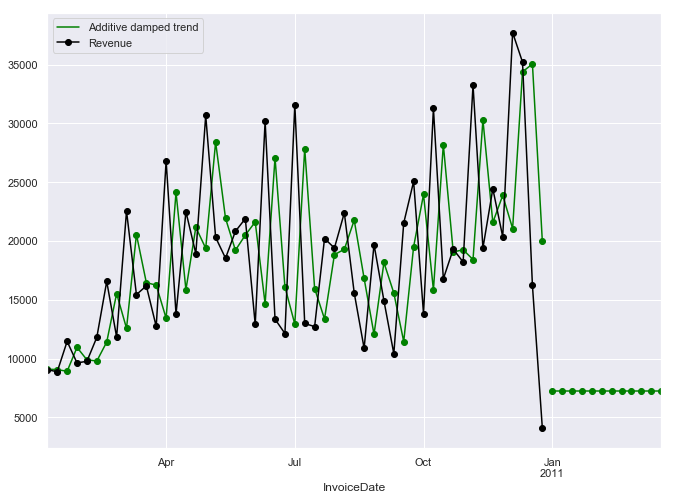

In [929]:
# fit1 = Holt(cluster_2_ts).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
# fcast1 = fit1.forecast(12).rename("Holt's linear trend")

# fit2 = Holt(cluster_2_ts, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
# fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(cluster_2_ts, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

# fit1.fittedvalues.plot(marker="o", color='blue')
# fcast1.plot(color='blue', marker="o", legend=True)
# fit2.fittedvalues.plot(marker="o", color='red')
# fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)
cluster_2_ts.plot(color='black', marker= "o", legend=True)

plt.show()

# Holt-Winters

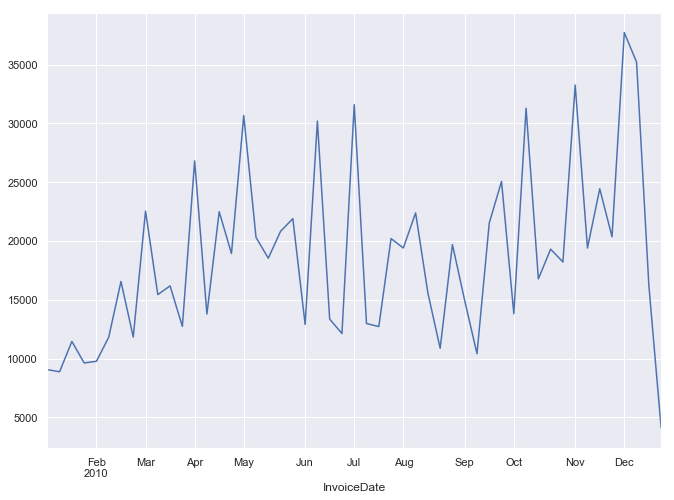

In [930]:
cluster_2_ts.plot()

In [923]:
fit1 = ExponentialSmoothing(cluster_2_ts,
                            trend='add',
                            seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(cluster_2_ts,
                            trend='add',
                            seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(cluster_2_ts,
                            trend='add',
                            seasonal='add',
                            damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(cluster_2_ts,
                            trend='add',
                            seasonal='mul',
                            damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

plt.show()
print(
    "Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality."
)

NotImplementedError: Unable to detect season automatically

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



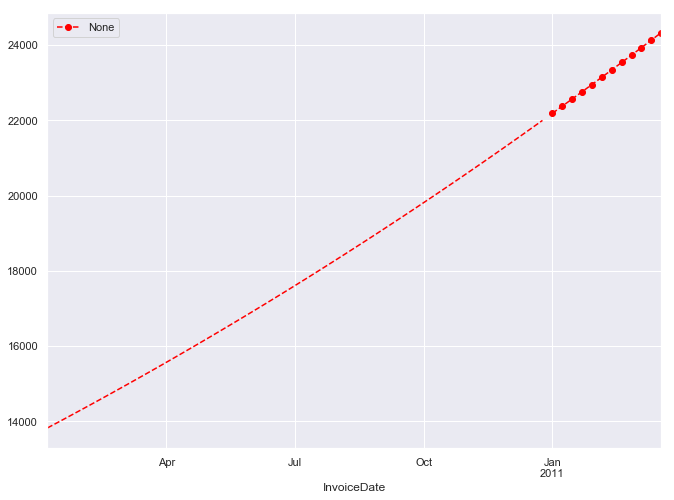

In [927]:
fit1 = ExponentialSmoothing(cluster_2_ts,
                            trend='add').fit(use_boxcox=True)
# fit2 = ExponentialSmoothing(cluster_2_ts,
#                             seasonal_periods=12,
#                             trend='add').fit(use_boxcox=True)
# fit3 = ExponentialSmoothing(cluster_2_ts,
#                             seasonal_periods=12,
#                             trend='add',
#                             damped=True).fit(use_boxcox=True)
# fit4 = ExponentialSmoothing(cluster_2_ts,
#                             seasonal_periods=12,
#                             trend='add',
#                             damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
# fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
# fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

plt.show()

# FB Prophet
- Use to assess how "best" model from Prophet looks with this short data

#### Prophet daily

In [ ]:
# # Get data into fb prophet format
# prophet_df = tseries.reset_index().rename(columns={"truncated_date": "ds", "Revenue": "y"})
# #prophet_df.set_index("ds",inplace=True)
# prophet_df.reset_index()
# prophet_df.head()

In [ ]:
prophet_daily = tseries.resample('D').sum()

In [ ]:
p_df = p.reset_index().rename(columns={"truncated_date": "ds", "Revenue": "y"})
p_df.head()

In [ ]:
p_df.info()

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet(yearly_seasonality=True)
m.add_c

# Fit data
m.fit(p_df)

# Create a dataframe of future dates up to periods
future = m.make_future_dataframe(periods=60)
future.tail()

In [ ]:
# Predict assigns each row in future a predicted value which it names yhat.
# Forecast is a new df that includes yhat column (predicted values)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Plot forecast
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

### Prophet weekly

In [ ]:
prophet_weekly = tseries_weekly_diff.reset_index().rename(columns={"truncated_date": "ds", "Revenue": "y"})
prophet_weekly.head()

In [ ]:
m_weekly = Prophet(yearly_seasonality=True)

# Fit data
m_weekly.fit(prophet_weekly)

# Create a dataframe of future dates up to periods
future_weekly = m_weekly.make_future_dataframe(periods=60)
future_weekly.tail()

In [ ]:
# Predict assigns each row in future a predicted value which it names yhat.
# Forecast is a new df that includes yhat column (predicted values)
forecast_weekly = m_weekly.predict(future_weekly)
forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Plot forecast
fig1_weekly = m_weekly.plot(forecast_weekly)

In [ ]:
fig2_weekly = m_weekly.plot_components(forecast_weekly)

In [ ]:
fig3_weekly = plot_plotly(m_weekly, forecast_weekly)  # This returns a plotly Figure
py.iplot(fig3_weekly)